# Finance Analytics

## How have major U.S. tech stocks performed and co-moved over the past five years, and what can this tell us about risk, return, and diversification in the sector?
This analysis replicates the type of sector research conducted by equity analysts and portfolio managers to evaluate performance, risk, and diversification opportunities within technology equities (Apple, Microsoft, Nvidia, Palantir, Amazon, Google). By examining risk-adjusted returns and inter-stock correlations among major U.S. tech companies, the analysis aims to inform strategic decisions around portfolio allocation, sector exposure, and investment timing.

## Data Collection & Description
Data will be collected via the yahoo finance library. This data is accurate, up to date, and with no missing values. To evaluate performance, we will be pulling the daily high, low, open, close, and volume of each stock as our core metrics and diving deeper.

### Setup

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.style.use("seaborn-v0_8")
sns.set_palette("muted")

print('Setup Complete')

Setup Complete


### Data Collection

In [ ]:
tickers = ['AAPL', 'MSFT', 'NVDA', 'AMZN', 'PLTR', 'GOOGL']
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

all_data = []
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    
    df = df.reset_index()
    
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Ticker'] = ticker
    
    all_data.append(df)

# Union all DataFrames
combined_df = pd.concat(all_data, ignore_index=True)

combined_df

/tmp/ipykernel_1623/29349653.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1623/29349653.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1623/29349653.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1623/29349653.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_1623/29349653.py:7: F

,Date,Close,High,Low,Open,Volume,Ticker
0,2020-10-29,112.173820,113.739897,109.138938,109.304306,146129200,AAPL
1,2020-10-30,105.890060,108.934664,104.781163,108.030037,190272600,AAPL
2,2020-11-02,105.802505,107.660400,104.392068,106.133233,122866900,AAPL
3,2020-11-03,107.426956,108.448305,105.763610,106.668237,107624400,AAPL
4,2020-11-04,111.813919,112.436458,109.284854,111.026020,138235500,AAPL
...,...,...,...,...,...,...,...
7519,2025-10-21,250.460007,254.880005,244.149994,254.740005,47312100,GOOGL
7520,2025-10-22,251.690002,256.359985,249.289993,254.369995,35029400,GOOGL
7521,2025-10-23,253.080002,255.039993,251.850006,252.979996,19901400,GOOGL
7522,2025-10-24,259.920013,261.679993,255.320007,256.579987,28607600,GOOGL


### Data Description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7524 entries, 0 to 7523
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7524 non-null   datetime64[ns]
 1   Close   7524 non-null   float64       
 2   High    7524 non-null   float64       
 3   Low     7524 non-null   float64       
 4   Open    7524 non-null   float64       
 5   Volume  7524 non-null   int64         
 6   Ticker  7524 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 411.6+ KB
None
------------------------------------
------------------------------------


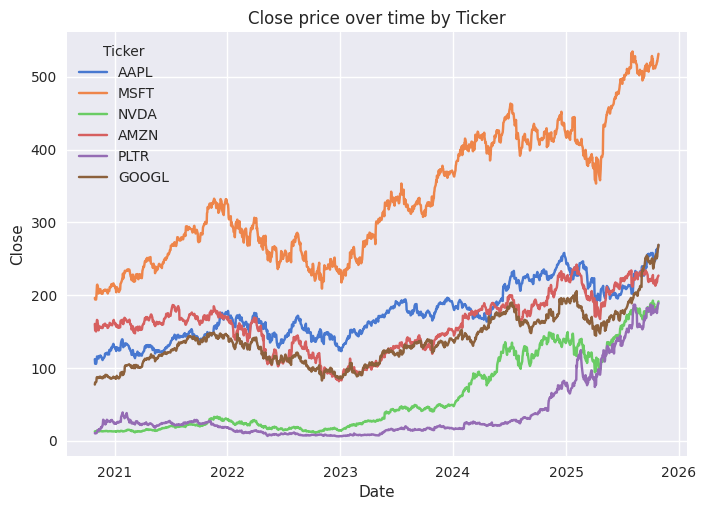

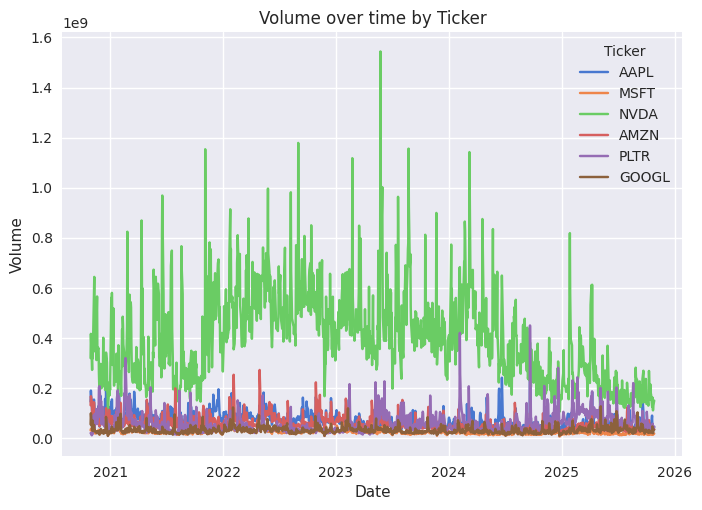

In [29]:
print(combined_df.info())
print('------------------------------------')
combined_df.describe()
print('------------------------------------')
sns.lineplot(data=combined_df, x='Date', y='Close', hue='Ticker')
plt.title('Close price over time by Ticker')
plt.show()
sns.lineplot(data=combined_df, x='Date', y='Volume', hue='Ticker')
plt.title('Volume over time by Ticker')
plt.show()

We can see that there aren't any nulls, datatypes are configured as they should be, and there are no extreme outliers around Close and Volume. The following patterns can be recognized from a first glance of the data
- Microsoft stock price has been much higher than that of its competitors
- There is a general growing trend across all equities
- Palantir has seen a sharp increase beginning around late 2024
- Apple, Google, and Amazon prices have intersected several times
- NVIDIA's daily volume traded far outweighs its competition

### Aggregating Metrics